## Arabic-Handwritten-recognition using Resnet-50

### You can get this dataset from [Link](https://www.kaggle.com/rashwan/arabic-chars-mnist)
The dataset is composed of 16,800 characters written by 60 participants. The database is partitioned into two sets: a training set (13,440 characters to 480 images per class) and a test set (3,360 characters to 120 images per class).

#### Citation
> Ahmed El-Sawy, Mohamed Loey, Hazem EL-Bakry, and their paper "Arabic Handwritten Characters Recognition using Convolutional Neural Network, WSEAS, 2017" 

### Using Transfer learning to fine-tune a [Resnet-50](https://arxiv.org/abs/1512.03385) trained on Imagenet to recognize handwritten characters.

*For more info about transfer learning in vision using FastAI see [fastai docs](https://docs.fast.ai/vision.learner.html#Transfer-learning)*

In [9]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [10]:
from fastai import *
from fastai.vision import *

In [11]:
data_path = Path('data')
input_size = 32
batch_size = 32

1. We create an image databunch from the the (train/test) folders labeling each image using a regular expression to get the name of the char from the file name.
2. For Data augmentaion we apply some random transformations to the images like (rotation,cropping) but we disable flipping the image as it is not useful in the case of characters.
3. We also normalize our images using the same stats from the Imagenet dataset.

In [15]:
arabic_labels = ['alef', 'beh', 'teh', 'theh', 'jeem', 'hah', 'khah', 'dal', 'thal',
                'reh', 'zain', 'seen', 'sheen', 'sad', 'dad', 'tah', 'zah', 'ain', 
                'ghain', 'feh', 'qaf', 'kaf', 'lam', 'meem', 'noon', 'heh', 'waw', 'yeh']
np.random.seed(42)
tfms = get_transforms(do_flip=False)
s = '([^/\d]+)\d+.jpg$'
data = (ImageList.from_folder(data_path)
        .split_by_rand_pct()
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size)
        .normalize(imagenet_stats))

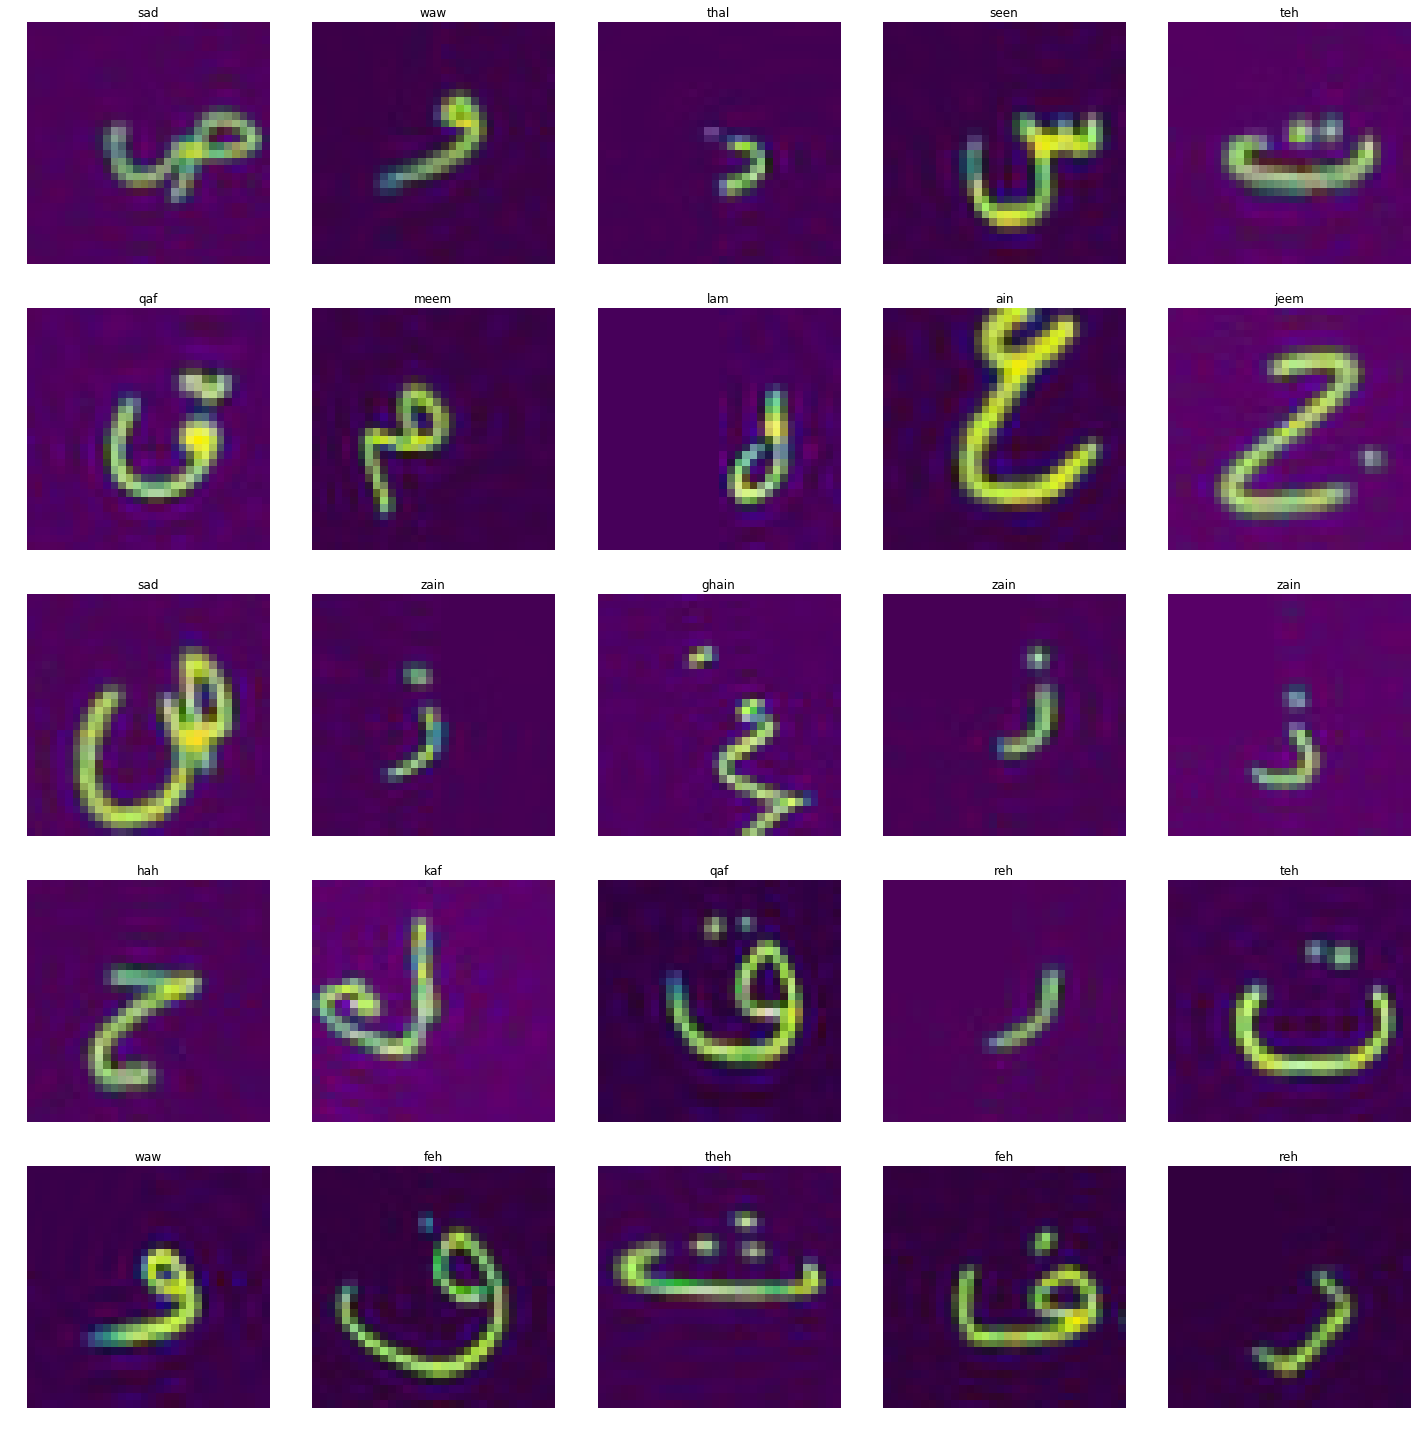

In [17]:
data.show_batch()

*We build a pretrained CNN we then need to change the last part of the model to be adapted to our data. Most convolutional models end with a few linear layers (head). The last convolutional layer will have analyzed features in the image that went through the model, and the job of the head is to convert those in predictions for each of our classes. In transfer learning we will keep all the convolutional layers (backbone) with their weights pretrained on ImageNet but will define a new head initialized randomly.*

In [26]:
learn = cnn_learner(data,models.resnet50,metrics=[accuracy],pretrained=True)

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


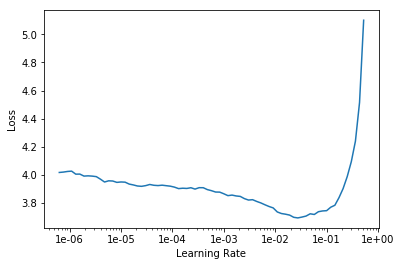

In [20]:
learn.recorder.plot()

**We train the model we obtain in two phases:**
1. We freeze the body weights and only train the head (to convert those analyzed features into predictions for our own data).
2. We unfreeze the layers of the backbone and fine-tune the whole model

In [22]:
learn.fit_one_cycle(4,3e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.107017,0.628736,0.785863,00:34
1,0.513266,0.268307,0.916369,00:28
2,0.295215,0.154218,0.949702,00:27
3,0.238425,0.126561,0.960863,00:27


In [23]:
learn.save('stage1-res50-4epoch')

In [28]:
learn.unfreeze()

In [29]:
learn.fit_one_cycle(5,max_lr=slice(1e-5,3e-3/5))

epoch,train_loss,valid_loss,accuracy,time
0,0.270438,0.155092,0.948661,00:35
1,0.271830,0.135936,0.955655,00:35
2,0.184183,0.106180,0.966518,00:35
3,0.126246,0.068679,0.979762,00:35
4,0.112506,0.063779,0.981845,00:35


In [30]:
learn.save('stage2-res50-5epoch')

*Now we can take a look at the most incorrect images that our model has predicted.*

In [31]:
interp = ClassificationInterpretation.from_learner(learn)


We can see that most of the images that our model got wrong are either very hard to recognize or labeled wrong.

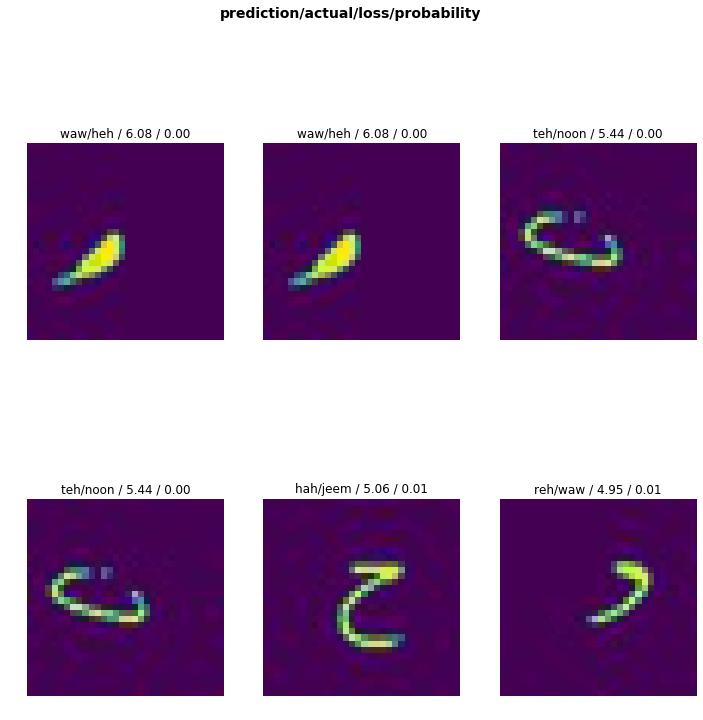

In [36]:
interp.plot_top_losses(6)

*We create a temp databunch containg our held-out test dataset to validate our classifer.*

In [38]:
s = '([^/\d]+)\d+.jpg$'
data_test = (ImageList.from_folder()
        .split_by_folder(train='train', valid='test')
        .label_from_re(s,classes = arabic_labels)
        .transform(tfms,size=input_size)
        .databunch(bs=batch_size) 
        .normalize(imagenet_stats))
        

learn.validate(data_test.valid_dl)

[0.04768665, tensor(0.9887)]

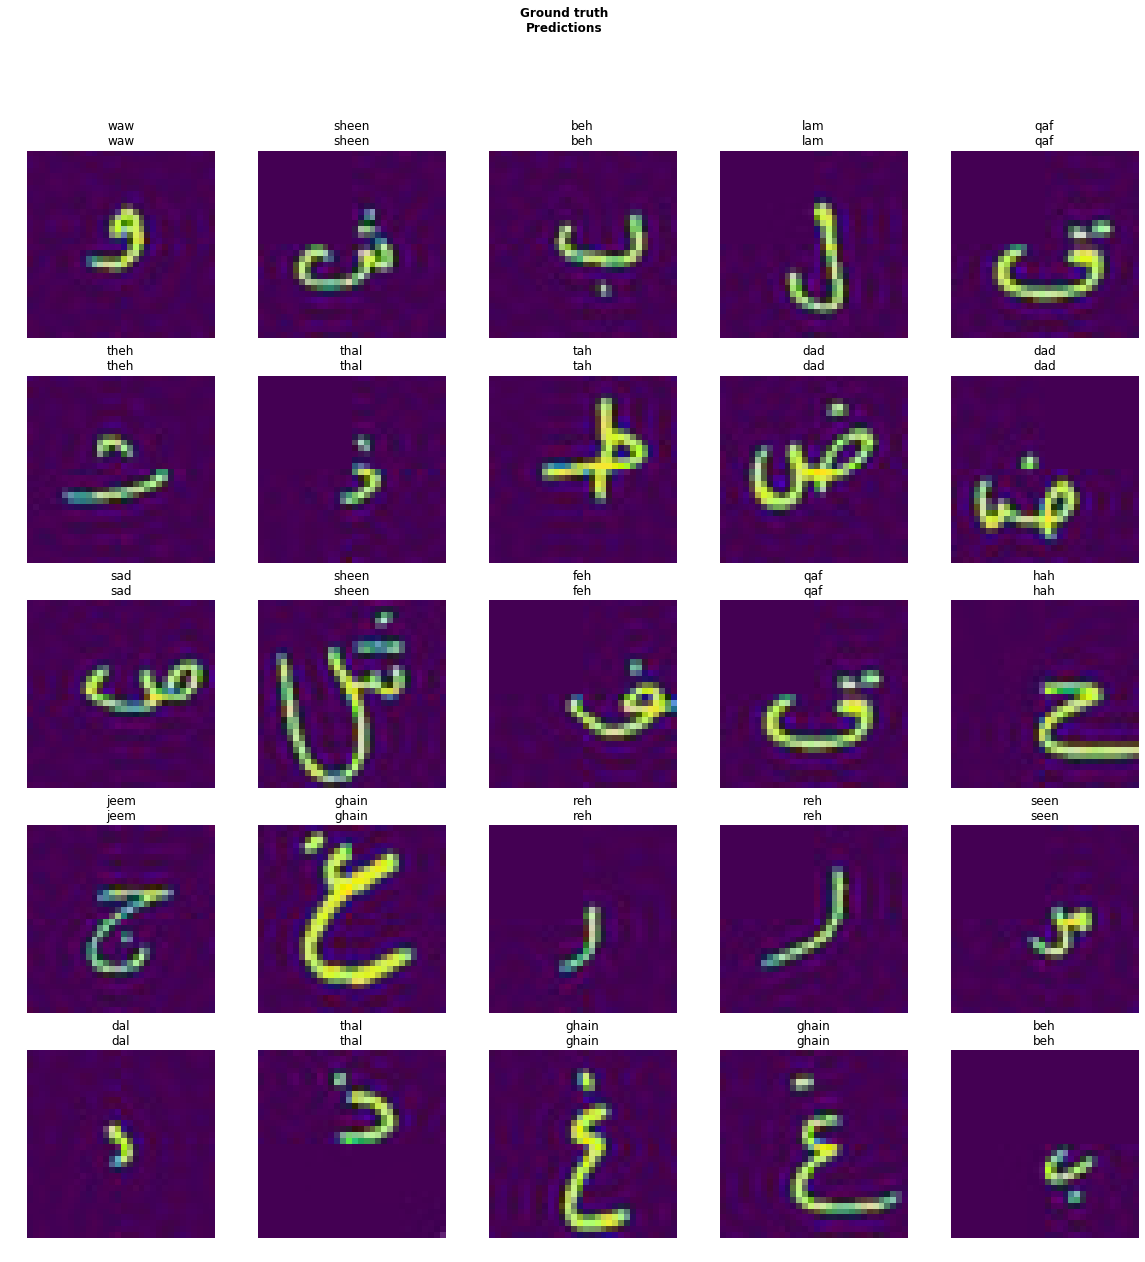

In [39]:
learn.show_results()